<a href="https://colab.research.google.com/github/Starath/MakalahMatdis/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transitleastsquares --quiet
!pip install lightkurve --quiet

import numpy as np
import matplotlib.pyplot as plt
import time

# Algoritma BLS
from astropy.timeseries import BoxLeastSquares

# Algoritma TLS
from transitleastsquares import transitleastsquares, cleaned_array

In [ ]:
def generate_synthetic_lightcurve(num_points=1000,
                                  transit_period=2.5,
                                  transit_depth=0.01,
                                  noise_level=0.001,
                                  random_seed=42):
    np.random.seed(random_seed)

    # Waktu dalam hari, kita asumsikan data diambil selama ~10 hari
    time = np.linspace(0, 10, num_points)

    # Flux baseline = 1.0
    flux = np.ones(num_points)

    # Sisipkan transit sederhana berbentuk "box"
    # Transit terjadi jika (time % transit_period) < transit_width
    transit_width = 0.05
    for i, t in enumerate(time):
        phase = (t % transit_period)
        if phase < transit_width:
            flux[i] -= transit_depth  # turunkan flux sebesar transit_depth

    # Tambahkan noise Gaussian
    flux += np.random.normal(0, noise_level, num_points)

    return time, flux


In [ ]:
def run_bls(time, flux, period_min=0.5, period_max=5.0):
    # Kita butuh array "flux_err" untuk BLS
    flux_err = np.ones_like(flux) * 0.0001

    # Inisialisasi objek BLS
    model = BoxLeastSquares(time, flux, flux_err)

    # Tentukan rentang periode (1000 titik periodik)
    periods = np.linspace(period_min, period_max, 1000)

    # Jalankan BLS (durasi transit diasumsikan tetap 0.02 hari untuk contoh)
    result = model.power(periods, 0.02)
    return result


In [ ]:
def run_tls(time, flux):
    """
    Menjalankan algoritma Transit Least Squares (TLS) untuk mencari periode transit.
    Mengembalikan objek hasil TLS agar bisa dianalisis lebih lanjut.
    """
    # Bersihkan data (mis. jika ada NaN)
    time_clean, flux_clean = cleaned_array(time, flux)

    # Inisialisasi model TLS
    model = transitleastsquares(time_clean, flux_clean)

    # Jalankan TLS (dengan semua parameter default)
    results = model.power()
    return results


In [ ]:
def time_module():
    return time.perf_counter()

In [ ]:
def compare_time_complexity(n_sizes):
    times_bls = []
    times_tls = []

    for n in n_sizes:
        # Generate data dummy
        time, flux = generate_synthetic_lightcurve(num_points=n)

        # Timing BLS
        start_bls = time_module()
        _ = run_bls(time, flux)
        end_bls = time_module()
        times_bls.append(end_bls - start_bls)

        # Timing TLS
        start_tls = time_module()
        _ = run_tls(time, flux)
        end_tls = time_module()
        times_tls.append(end_tls - start_tls)

    return times_bls, times_tls

In [ ]:
# Di sini kita uji pada beberapa ukuran data yang berbeda
n_sizes = [500, 1000, 2000, 4000, 8000]

# Panggil fungsi pembanding waktu
times_bls, times_tls = compare_time_complexity(n_sizes)

# Tampilkan hasil di layar
print("Ukuran data (N):", n_sizes)
print("Waktu BLS (s):   ", times_bls)
print("Waktu TLS (s):   ", times_tls)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 31 durations
Searching 499 data points, 713 periods from 0.602 to 4.99 days
Using all 2 CPU threads


100%|██████████| 713/713 periods | 00:06<00:00


Searching for best T0 for period 2.50078 days
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 31 durations
Searching 999 data points, 714 periods from 0.602 to 4.995 days
Using all 2 CPU threads


100%|██████████| 714/714 periods | 00:09<00:00


Searching for best T0 for period 2.50433 days
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 31 durations
Searching 1999 data points, 715 periods from 0.601 to 4.997 days
Using all 2 CPU threads


100%|██████████| 715/715 periods | 00:07<00:00


Searching for best T0 for period 2.49754 days
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 31 durations
Searching 3999 data points, 715 periods from 0.601 to 4.999 days
Using all 2 CPU threads


100%|██████████| 715/715 periods | 00:12<00:00


Searching for best T0 for period 2.49842 days
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 31 durations
Searching 7999 data points, 715 periods from 0.601 to 4.999 days
Using all 2 CPU threads


100%|██████████| 715/715 periods | 00:15<00:00


Searching for best T0 for period 2.49886 days
Ukuran data (N): [500, 1000, 2000, 4000, 8000]
Waktu BLS (s):    [0.025312980000080643, 0.027359697000065353, 0.04358363599999393, 0.057830918000036036, 0.09643961799997669]
Waktu TLS (s):    [6.5951527900001565, 9.539705378999997, 7.528058421999958, 12.744148288000133, 16.874778006000042]


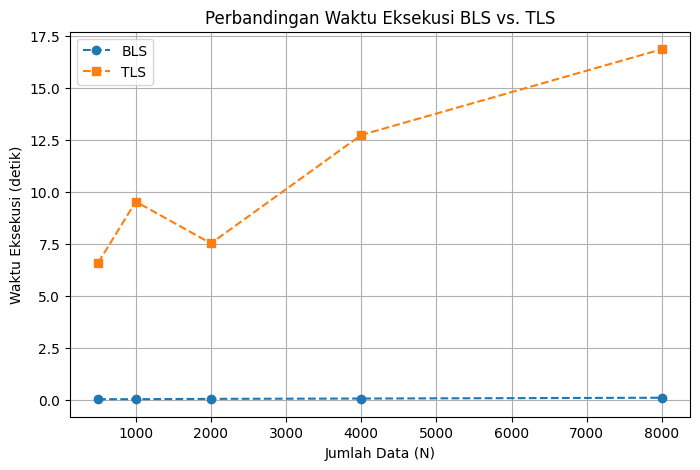

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_sizes, times_bls, 'o--', label='BLS')
plt.plot(n_sizes, times_tls, 's--', label='TLS')
plt.xlabel('Jumlah Data (N)')
plt.ylabel('Waktu Eksekusi (detik)')
plt.title('Perbandingan Waktu Eksekusi BLS vs. TLS')
plt.legend()
plt.grid(True)
plt.show()